<h1 style='text-align:center;'> Around the World with Genetic Algorithms </h1>
<h3 style='text-align:center;'>Master II Livello in Data Science for Economics, Business and Finance</h3> 
<h4 style='text-align:center;'>Università Degli Studi Di Milano</h4> 
<h4 style='text-align:center;'>Massimo Montanaro</h4>
<br>
<p>The aim of this work is to create a <i>spider</i> able to scrape the geographical coordinates of all the states of the world and compare the performance of two <i>genetic algorithms</i>. StatesSpider is a simple spider that retrieves the URLs of each state from the Wikipedia page where all the states in the world are listed. It then visits all the retrieved URLs to scrape: state name, latitude and longitude.</p>

<p>The scraped data was subjected to cleaning and transformed into Cartesian coordinates for a two-dimensional representation. Only the indexes of the states and the Cartesian coordinates were inserted into arrays to facilitate the designing of genetic algorithms. Minimizing a cost function is the problem that the two algorithms face. In particular it is the classic <i>Traveller Salesman Problem</i> which consists in searching for the path with the minimum length that passes through all the points (exactly one time) reaching the starting point at the end.</p>

<p> <i><b>N.B.</b> Since the data has been forced into a two-dimensional space, the way the algorithms work is not to be considered of real use. In fact, in this case there is no way to trace a path connecting Australia to the United States continuing eastwards, but it is necessary to trace a route to the west which turns out to be much longer and absolutely expensive in reality</i>.</p>

<h2>Web Scraping</h2>

In [4]:
from IPython.display import Image

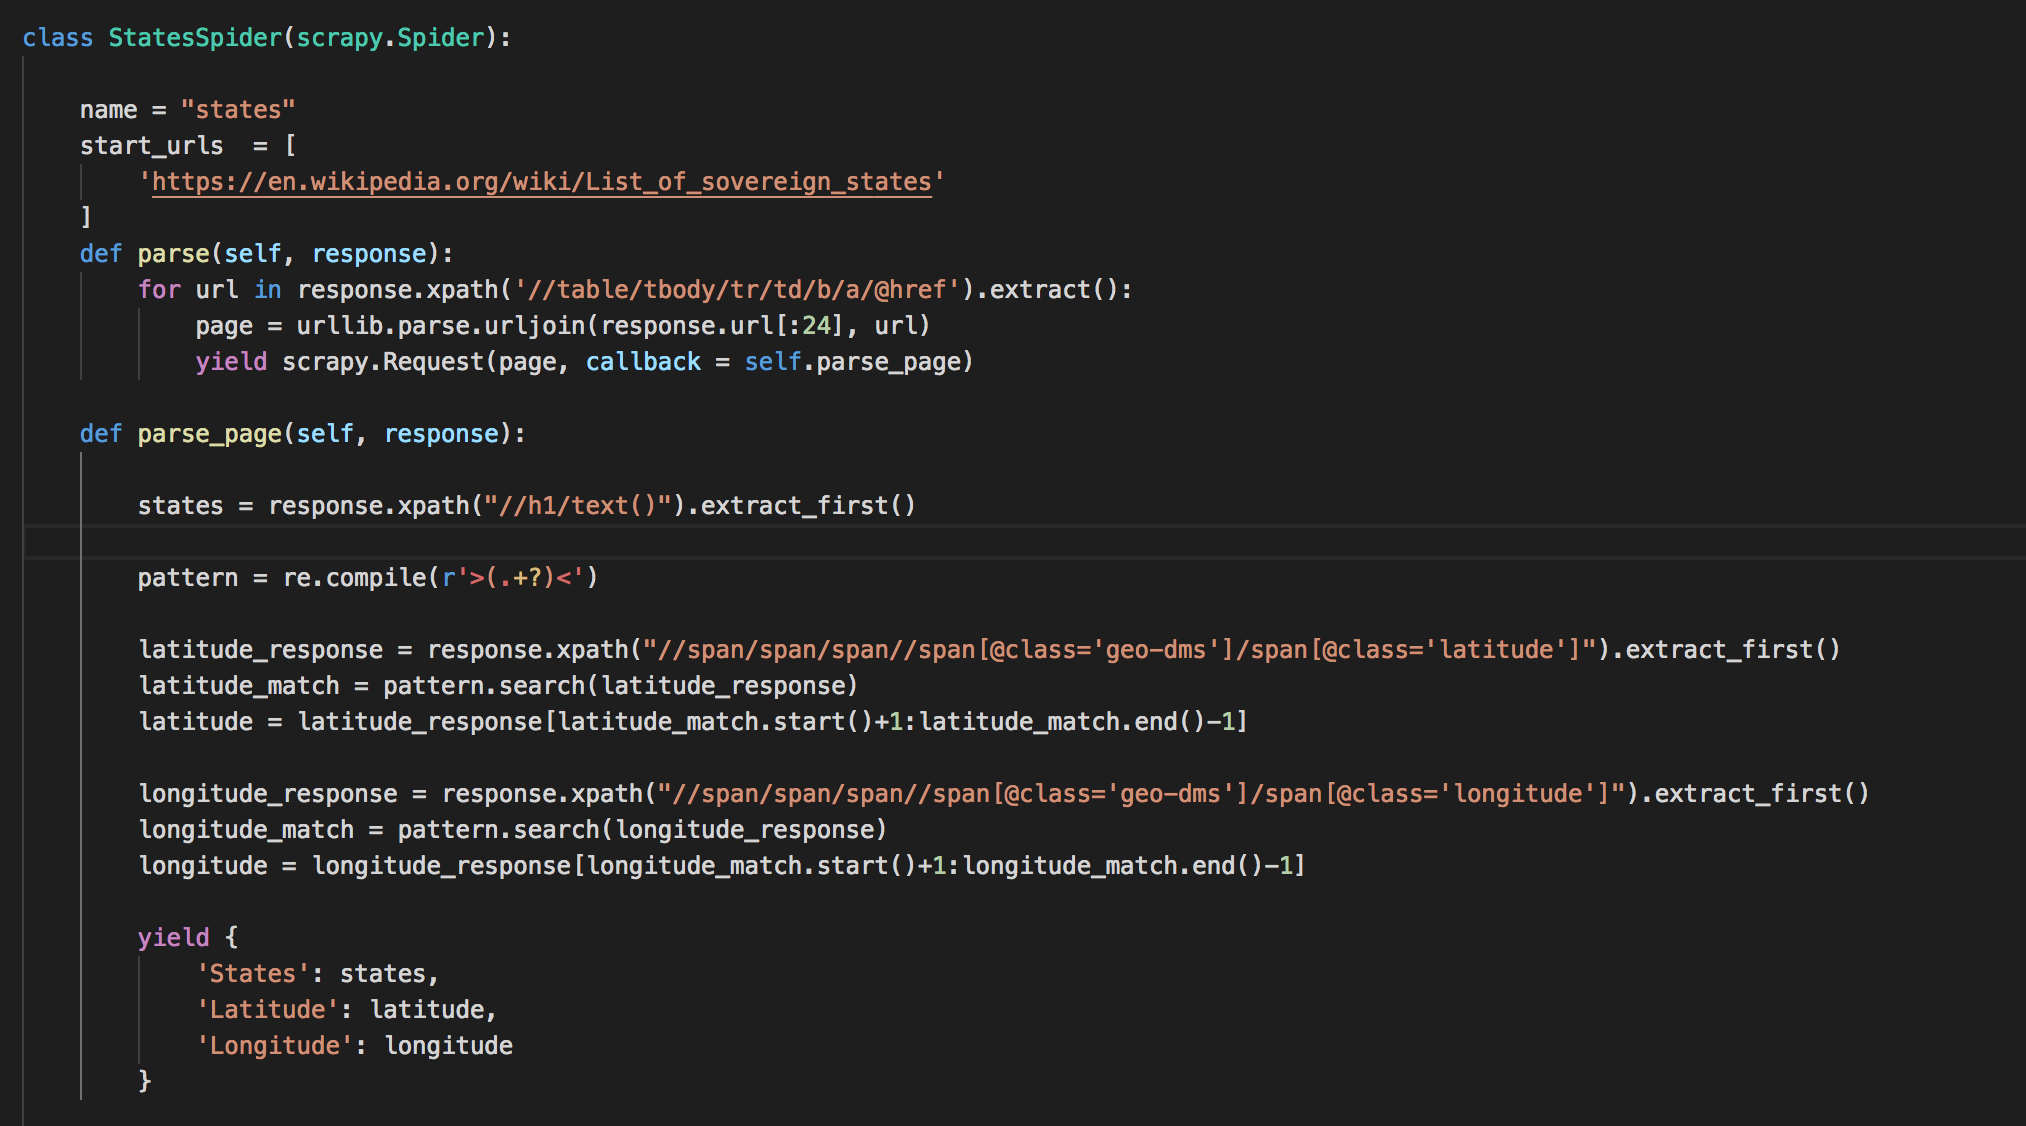

In [6]:
Image(filename='spider.jpg', width = 500, height=250) 

<p>
From the statistics we can see how the information related to 8 states have not been correctly scraped.</p>

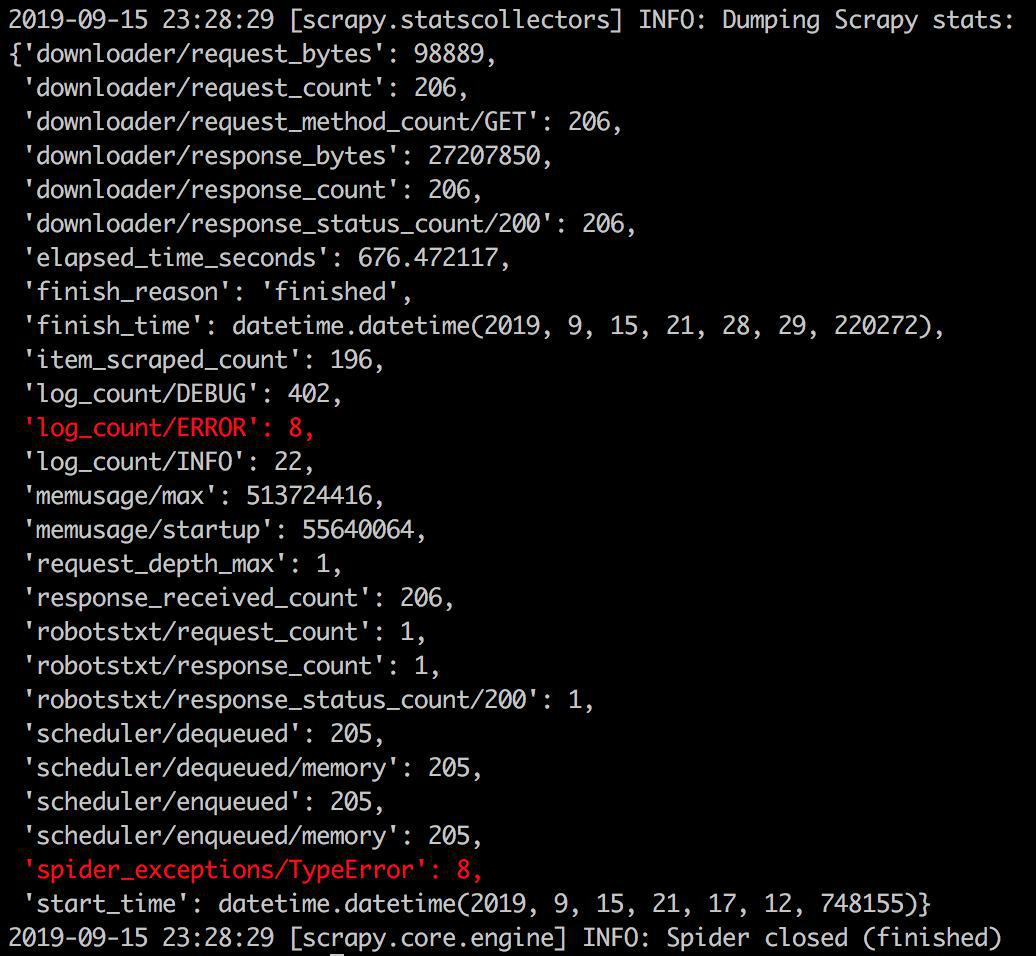

In [7]:
Image(filename='scrapy_stats.jpg', width = 350, height=250) 

In [3]:
import numpy as np
import pandas as pd
import re
import random
from tqdm import tqdm

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df = pd.read_csv('stati_coordinate.csv')

In [11]:
df.columns = ['States', 'Latitude', 'Longitude']

In [12]:
'Number of rows: {}'.format(df.shape[0])

'Number of rows: 196'

In [13]:
df.head(10)

,States,Latitude,Longitude
0,Afghanistan,33°N,65°E
1,Angola,12°30′S,18°30′E
2,Algeria,28°N,2°E
3,Armenia,40°N,45°E
4,Albania,41°N,20°E
5,Andorra,42°30′N,1°31′E
6,The Bahamas,24°15′N,76°00′W
7,Antigua and Barbuda,17°03′N,61°48′W
8,Azerbaijan,40°18′N,47°42′E
9,Bahrain,26°01′39″N,50°33′00″E


<h4>Data Cleaning</h4>

<p>Using regular expressions to extract only the information related to degrees and minutes and store the cardinal labels separately.</p>

In [14]:
pattern = re.compile(r'\d+')
counter = 0
for c1 in range(1,3):
    cardinal = []
    coordinate = []
    for c2 in range(df.shape[0]):
        text = df.iat[c2,c1]
        cardinal.append(text[-1])
        matches = pattern.findall(text)
        values = [match for match in matches]
        if len(values) == 1:
            number = values[0]
            coordinate.append(float(number))
        elif len(values) >= 1:
            number = float(str(values[0]) + '.' + str(values[1]))
            coordinate.append(number)
    col_name_1 = 'Coordinates'+ ' ' + df.columns[c1]
    col_name_2 = 'Cardinal'+ ' ' +df.columns[c1]
    df.insert(c1+2+counter, col_name_1, coordinate)
    df.insert(c1+3+counter, col_name_2, cardinal)
    counter += 1

In [15]:
df.head(10)

,States,Latitude,Longitude,Coordinates Latitude,Cardinal Latitude,Coordinates Longitude,Cardinal Longitude
0,Afghanistan,33°N,65°E,33.00,N,65.00,E
1,Angola,12°30′S,18°30′E,12.30,S,18.30,E
2,Algeria,28°N,2°E,28.00,N,2.00,E
3,Armenia,40°N,45°E,40.00,N,45.00,E
4,Albania,41°N,20°E,41.00,N,20.00,E
5,Andorra,42°30′N,1°31′E,42.30,N,1.31,E
6,The Bahamas,24°15′N,76°00′W,24.15,N,76.00,W
7,Antigua and Barbuda,17°03′N,61°48′W,17.03,N,61.48,W
8,Azerbaijan,40°18′N,47°42′E,40.18,N,47.42,E
9,Bahrain,26°01′39″N,50°33′00″E,26.01,N,50.33,E


In [16]:
'Latitude Max: {}, Latitude Min: {}, Longitude Max: {}, Longitude Min: {}'.format(df.iloc[:,3].max(), 
                                                                                  df.iloc[:,3].min(), 
                                                                                  df.iloc[:,5].max(), 
                                                                                  df.iloc[:,5].min())

'Latitude Max: 65.0, Latitude Min: 0.32, Longitude Max: 179.11, Longitude Min: 1.03'

<h4>

Transformation of cardinal coordinates into Cartesian coordinates within the positive quadrant of x and y.</h4>

In [17]:
list_lat = []
list_long = []

for c in range(df.shape[0]):
    if df.iat[c,4] == 'N':
        coor = df.iat[c,3] + 66
        list_lat.append(coor)
    elif df.iat[c,4] == 'S':
        coor = 66 - df.iat[c,3]
        list_lat.append(coor)
        
    if df.iat[c,6] == 'E':
        coor = df.iat[c,5] + 180
        list_long.append(coor)
    elif df.iat[c,6] == 'W':
        coor = 180 - df.iat[c,5]
        list_long.append(coor)

In [18]:
df.insert(1, 'X', list_long)
df.insert(2, 'Y', list_lat)

In [19]:
df.head(5)

,States,X,Y,Latitude,Longitude,Coordinates Latitude,Cardinal Latitude,Coordinates Longitude,Cardinal Longitude
0,Afghanistan,245.0,99.0,33°N,65°E,33.0,N,65.0,E
1,Angola,198.3,53.7,12°30′S,18°30′E,12.3,S,18.3,E
2,Algeria,182.0,94.0,28°N,2°E,28.0,N,2.0,E
3,Armenia,225.0,106.0,40°N,45°E,40.0,N,45.0,E
4,Albania,200.0,107.0,41°N,20°E,41.0,N,20.0,E


<h4>Data Visualization</h4>

In [20]:
def find_state_index(state_name):
    
    states = list(df.iloc[:,0])
    state_index = states.index(state_name)
    
    return state_index

<p>I choose <i>Italy</i> as start and end point, so i use <i>find_state_index( )</i> function to find its index.</p>

In [47]:
start_index = find_state_index('Italy')
states_index = np.delete(np.arange(0, df.shape[0],1), start_index)

<p>
I also retrieve the indexes of some states whose positions are known enough to have some points of reference in the scatter plot.</p>

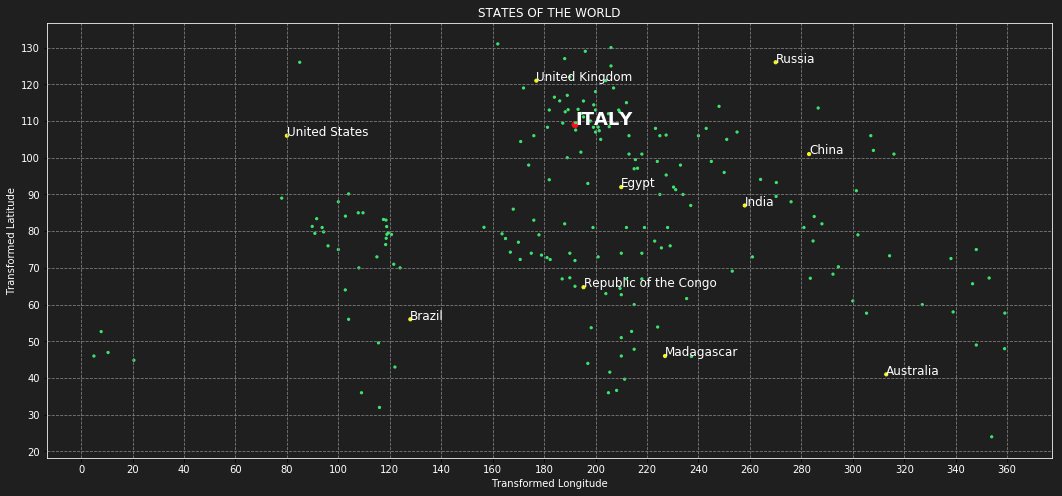

In [22]:
plot_some_state = ['United States', 'Brazil', 'United Kingdom', 'Egypt', 'Republic of the Congo', 
                   'Madagascar', 'Russia', 'China', 'India', 'Australia']

plot_some_state_index = []

for i in plot_some_state:
    plot_some_state_index.append(find_state_index(i))
    
color = []
size = []

for i in range(df.shape[0]):
    if i == start_index:
        color.append('#FB0D1B')
        size.append(35)
    elif i in plot_some_state_index:
        color.append('#F8F622')
        size.append(10)
    else:
        color.append('#3DE66E')
        size.append(5)

x = [i for i in df.iloc[:,1]]
y = [i for i in df.iloc[:,2]]

fig, ax = plt.subplots(figsize=(18,8))
fig.patch.set_facecolor(color=(0.12,0.12,0.12))

ax.set_facecolor((0.12,0.12,0.12))
ax.set_title('STATES OF THE WORLD', color = (1,1,1))
ax.set_xlabel('Transformed Longitude', color = (1,1,1))
ax.set_ylabel('Transformed Latitude', color = (1,1,1))

ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.yticks(np.arange(0,140,10),color=(1,1,1))
plt.xticks(np.arange(0,400, 20),color=(1,1,1))

ax.scatter([x], y, c = color, s = size)

for i in range(df.shape[0]):
    if i == start_index:
        ax.annotate((df.iat[i,0]).upper(), (x[i], y[i]), color='white', weight='bold', fontsize = 18)
    elif i in plot_some_state_index:
        ax.annotate(df.iat[i,0], (x[i], y[i]), color='white', fontsize=12)

<p>
The transformation approximates the positions of the States quite well</p>

In [23]:
data = np.zeros((df.shape[0],3))
data[:,0] = np.arange(0,df.shape[0],1, dtype = int)
data[:,1] = df.iloc[:,1]
data[:,2] = df.iloc[:,2]

In [24]:
cga_data = pd.DataFrame(data)

<h2>Genetic Algorithms</h2>
<p>Genetic algorithms are <i>heuristic-based</i> algorithms and are generally used to solve optimization problems for which other algorithms of linear or polynomial complexity are not known. 
The term <i>'Genetic'</i> is based on <i>Darwin’s theory of evolution</i>: individual variations are transmitted to the next generation only by those individuals of the previous one who appeared to be favored in the struggle for survival. The strategy often used by these algorithms is to generate combinations of random values to explore the form of the function and search for the maximum or minimum point of that function.</p>

<p> As we'll see, in the Traveller Salesman Problem, the algorithms generate a population of <i>n</i> random paths (each of which passes only once for each point and reach the starting point at the end). Then these routes are evaluated and sorted based on the sum of distances between each point within the route. Among the generated routes, those with minimum lengths contain good information on the order in which the points must be crossed to decrease the total length of the route. The latter correspond to the best individuals who will transmit individual variance to the next generation. However not all the subsequent population will be generated by the best of the previous generation. A part of the population will still be randomly generated. The goal of this operation is to prevent the algorithm to be blocked in a local minimum. The operations of generation of the population and selection of the best are repeated for the number of generations desired.</p>


<h3>Standard Genetic Algorithm</h3>
<ol>
    <li>generate the population of random paths;</li>
    <li>sort the population based on the total length of the route;</li>
    <li> <i>if</i> the current population is the first: save the best route and use its length to compare the best of the next generation; <i>else</i>: if the best of the new generation has a lower total length than the saved one, use this to compare the next and replace the old best route with the new one;</li> 
<li>select two random paths from the best;</li>
    
<li>generate a new path by replacing a random section of the first path with the same points as the second one, which most likely have a different order;</li>
    
    <li>generate a random number, if this is greater than the <i>'genetic_mutation'</i> parameter, two random points in the path are selected and exchanged between them;</li>
    
    <li>steps 4, 5, and 6 are repeated <i>new_pop</i> times, where new_pop is the number of routes of the new population that you choose to generate from the previous one, the remaining part is created by generating random paths;</li>

    <li>return to step number 2 <i>n_gen</i> times.</li>
</ol>
    
    

In [25]:
def create_random_route(states_index):
    
    route = random.sample(list(states_index), states_index.shape[0])
    
    return route #list

In [26]:
def create_population(size, states_index):

    population = np.zeros((len(states_index), size), dtype = int)
    
    for c in range(size):
        population[:,c] = create_random_route(states_index = states_index)
    
    return population #array

In [27]:
def find_distance (state_1, state_2, data):
    
    state_1_x = data[state_1, 0]
    state_1_y = data[state_1, 1]
    
    state_2_x = data[int(state_2), 0]
    state_2_y = data[int(state_2), 1]
    
    xdistance = abs(state_1_x - state_2_x)
    ydistance = abs(state_1_y - state_2_y)
    
    distance = np.sqrt((xdistance**2) + (ydistance**2))
    
    return distance

In [28]:
def evaluate_population(data, population, start_index):
    
    fitness_path = []
    
    for c in range(population.shape[1]):
        
        route = list(population[:,c])
        length =  np.sum([find_distance(route[int(x)], route[int(x+1)], data) for x in range(len(route)) if x <= (len(route)-2)])
        total_length = length + find_distance(start_index, route[0], data) + find_distance(route[-1], start_index, data)
        fitness_path.append(total_length)
    
    ordered_index = np.argsort(fitness_path)
    ordered_fitness = [fitness_path[i] for i in ordered_index]
    ordered_population = population[:,ordered_index]
    
    return ordered_population, ordered_fitness[0] #array, value

In [49]:
def genetic_mutation(list_1, list_2, mutation_rate):
    
    new_individual = []
    new_individual_p1 = []
    new_individual_p2 = []
    
    start_mating = int(np.random.random() * (len(list_1) / 2))
    end_mating = int(np.random.randint(start_mating, len(list_1), 1))
    
    new_individual_p1 = list_1[:start_mating] + list_1[end_mating:]
    new_individual_p2 = [c for c in list_2 if c not in new_individual_p1]
    new_individual = list_1[:start_mating] + new_individual_p2 + list_1[end_mating:]
    
    for switch in range(1,len(new_individual)-1):
        if np.random.random() < mutation_rate:
            switch_with = int(np.random.random() * (len(new_individual) -2)) +1
            
            gene_1 = new_individual[switch]
            gene_2 = new_individual[switch_with]
            
            new_individual[switch] = gene_2
            new_individual[switch_with] = gene_1
    
    return new_individual

In [30]:
def next_generation(ordered_population, n_best, size, mutation_rate, data, states_index, start):
    
    best_individuals = ordered_population[:,:n_best]
    
    new_population = np.zeros((best_individuals.shape[0], size), dtype = int)
    
    for c in range(n_best):
        match_index = list(np.random.randint(0,n_best,2))
        parent_1 = list(best_individuals[:,match_index[0]])
        parent_2 = list(best_individuals[:,match_index[1]])
        new_population[:,c] = genetic_mutation(parent_1, parent_2, mutation_rate)
        
    other = size - n_best 
    new_random_individuals = create_population(other, states_index)
    new_population[:,n_best:] = new_random_individuals
        
    return new_population   #array

In [31]:
def standard_genetic_algorithm(dataframe, data, size, states_index, start, n_gen, n_best, mutation_rate):
    
    all_fitness = [] 
    
    population = create_population(size, states_index)
    ordered_population, fitness = evaluate_population(data, population, start_index)
    
    length_route = fitness
    all_fitness.append(fitness)
    
    for c in tqdm(range(n_gen)):
        
        new_population = next_generation(ordered_population, n_best, size, mutation_rate, data, states_index, start)
        ordered_population, fitness = evaluate_population(data, new_population, start_index)
        all_fitness.append(fitness)
        
        if fitness < length_route:
            length_route = fitness
            best_path = dataframe.iloc[list(ordered_population[:,0]), 0]
     
    return length_route, best_path, all_fitness

<h3>Clustered Genetic Algorithm</h3>

<ol>
<li>Clustering points in <i>n</i> clusters.</li>
<li>Create an array containing the cluster labels and the respective probabilities of being extracted (<i>start_prob</i>). The probability of each cluster is initially set to 1. </li>
<li>Create an array containing the conditional probabilities of extracting the other clusters after one has already been extracted (<i>cluster_path_prob</i>). This array contains <i>n_cluster x (n_cluster-1)</i> probabilities. Each of these probabilities is initially set to 1.</li>
<li>Create a list containing an array for each cluster. Each array contains the conditional probabilities of choosing all the other points of the same cluster after one has already been chosen. All these arrays contain <i>n_points_cluster x (n_points_cluster - 1)</i> probabilities. Each probability is initially set to 1.</li>
<li>Sample a cluster with weights. </li>
<li>Generate the cluster path by sampling each subsequent cluster with weights.</li>
<li>For each cluster, sample all cluster points with weights. Add the starting point to the beginning and end of the newly generated route.</li>
<li>Repeat steps 5, 6 and 7 <i>population_size</i> times.</li>
<li>Sort the population based on the total length of the route.</li>
<li>Select the first <i>length_tail</i> paths and increase the probability of the starting cluster and the conditional probabilities of <i>cluster_path</i> and <i>cluster_points_path</i>.</li>
<li>Select the last <i>length_tail</i> paths and decrease the probability of the starting cluster and the conditional probabilities of <i>cluster_path</i> and <i>cluster_points_path</i>.</li>
<li><i>If</i> the current population is the first: save the best route and use its length to compare the best of the next generation; <i>else</i>: if the best of the new generation has a lower total length than the saved one, use this to compare the next and replace the old best route with the new one.</li>
<li>Return to step number 5 for <i>n_gen</i> times.</li>
</ol>

In [32]:
def cga_clustering (data, n_cluster):
    
    clust_data = np.array(data.iloc[:,1:])
    
    km = KMeans(n_clusters = n_cluster,
                init = 'k-means++', 
                n_init = 10,
                max_iter = 500,
                tol = 1e-04,
                random_state = 0)
    
    labeled_data = km.fit_predict(clust_data)
    
    clustered_data = np.zeros((clust_data.shape[0], 4), dtype = int)
    clustered_data[:,0] = np.arange(0,data.shape[0],1,dtype=int)
    clustered_data[:,1] = labeled_data
    clustered_data[:,2] = clust_data[:,0]
    clustered_data[:,3] = clust_data[:,1]
    
    clustered_data = pd.DataFrame(clustered_data)
    clustered_data.columns = ['Index', 'Cluster', 'X', 'Y']
    
    # pandas dataframe
    return clustered_data

In [33]:
def cga_create_probability_start_table(clustered_data):
    
    n_cluster = np.unique(clustered_data.iloc[:,1].tolist()).shape[0]
    start_table = np.zeros((n_cluster, 2))
    
    start_table[:,0] = np.arange(0,n_cluster,1)
    start_table[:,1] = np.ones((n_cluster))
    
    return start_table

In [34]:
def cga_create_cluster_probability_table(clustered_data):
    
    n_cluster = np.unique(clustered_data.iloc[:,1].tolist()).shape[0]
    
    probability_table = np.zeros((n_cluster*(n_cluster-1),3))
    cluster_label = np.arange(0,n_cluster,1,dtype = int)
    
    c = 0
    for i in cluster_label:
        other = cluster_label[cluster_label != i]
        for ii in other:
            probability_table[c,0] = i
            probability_table[c,1] = ii
            probability_table[c,2] = 1
            c += 1
    # numpy array        
    return probability_table

In [35]:
def cga_create_path_probability_list(clustered_data):
    
    n_cluster = np.unique(clustered_data.iloc[:,1].tolist())
    
    probability_list = []
    
    for i in n_cluster:
        sub_data = clustered_data[clustered_data[clustered_data.columns[1]] == i]
        nodes = np.array(sub_data.iloc[:,0].tolist())
        probs = []
        for ii in nodes:
            other = nodes[nodes != ii]
            for iii in other:
                single_node_chance = [ii, iii, 1]
                probs.append(single_node_chance)
        probability_list.append(probs)
        
    # list   
    return probability_list

In [36]:
def cga_generate_random_sequence(probability_table, start_table = None, weights = False):
    
    choosed = []
    n_cluster = np.unique(probability_table[:,0])
    
    if start_table is None:
        start = np.random.choice(n_cluster, 1, replace = False)[0]
    else:
        start = np.random.choice(n_cluster, 1, replace = False, p = start_table[:,1]/np.sum(start_table[:,1]))[0]
    
    while True:
        choosed.append(start)
        if len(choosed) == n_cluster.shape[0]:
            break
        else:
            other = np.array([i for i in n_cluster if i not in choosed])
            probs = probability_table[probability_table[:,0] == start]
            new_prob_table = np.array([[probs[i,1], probs[i,2]] for i in range(probs.shape[0]) if probs[i,1] not in choosed])
            if weights != False:
                start = np.random.choice(new_prob_table[:,0], 1, replace = False, p = new_prob_table[:,1]/np.sum(new_prob_table[:,1]))[0]
            else:
                start = np.random.choice(new_prob_table[:,0], 1, replace = False)[0]
    
    return choosed

In [37]:
def cga_create_path(probability_table, probability_list,  weights = False, start_table = None):
    
    cluster_path = np.array(cga_generate_random_sequence(probability_table, start_table = start_table, weights=weights), dtype=int)
    
    path = []
    
    for i in cluster_path:
        path.append(cga_generate_random_sequence(np.array(probability_list[i]), weights=weights))
        
    path = np.array([item for subpath in path for item in subpath])
    
    # cluster_path = numpy array 1d; path = numpy array 1d
    return cluster_path, path

In [38]:
def cga_find_distance_from_start(start_data, item, clustered_data):
    
    x_start = start_data.loc[1]
    y_start = start_data.loc[2]
    
    x_item = clustered_data[clustered_data[clustered_data.columns[0]] == item].iat[0,2]
    y_item = clustered_data[clustered_data[clustered_data.columns[0]] == item].iat[0,3]
    
    xdistance = abs(x_start - x_item)
    ydistance = abs(y_start - y_item)
    
    distance = np.sqrt((xdistance**2) + (ydistance**2))
    
    return distance

In [39]:
def cga_find_distance(item_1, item_2, clustered_data):
    
    x_item_1 = clustered_data[clustered_data[clustered_data.columns[0]] == item_1].iat[0,2]
    y_item_1 = clustered_data[clustered_data[clustered_data.columns[0]] == item_1].iat[0,3]
    
    x_item_2 = clustered_data[clustered_data[clustered_data.columns[0]] == item_2].iat[0,2]
    y_item_2 = clustered_data[clustered_data[clustered_data.columns[0]] == item_2].iat[0,3]
    
    xdistance = abs(x_item_1 - x_item_2)
    ydistance = abs(y_item_1 - y_item_2)
    
    distance = np.sqrt((xdistance**2) + (ydistance**2))
    
    # scalare
    return distance

In [40]:
def cga_create_population(probability_table, probability_list, size, weights = False, start_table = None):
    
    clust_path_1, path_1 = cga_create_path(probability_table, probability_list, weights, start_table = start_table)
    n_rows_clust = clust_path_1.shape[0]
    n_rows_path = path_1.shape[0]
    
    clust_pop = np.zeros((n_rows_clust, size), dtype = int)
    clust_pop[:,0] = clust_path_1
    
    population = np.zeros((n_rows_path,size), dtype = int)
    population[:,0] = path_1
    
    for i in range(1,size):
        clust_pop[:,i], population[:,i] = cga_create_path(probability_table, probability_list, weights, start_table = start_table)
    
    # clust_pop: numpy array; population: numpy array
    return clust_pop, population

In [41]:
def cga_evaluate_population(clust_pop, population, start_data, clustered_data):
    
    fitness_list = []
    
    for i in range(population.shape[1]):
        path = population[:,i]
        length = np.sum([cga_find_distance(path[x], path[x+1], clustered_data) for x in range(path.shape[0]) if x <= (path.shape[0]-2)])
        total_length = cga_find_distance_from_start(start_data, path[0], clustered_data) + length + cga_find_distance_from_start(start_data, path[-1], clustered_data)
        
        fitness_list.append(total_length)
        
    ordered_ind = np.argsort(fitness_list)
    
    ordered_clust_pop = clust_pop[:,ordered_ind]
    ordered_population = population[:,ordered_ind]
    best_fitness = fitness_list[ordered_ind[0]]
    
    # best_fitness: scalare; ordered_clust_pop, ordered_population: numpy array
    return best_fitness, ordered_clust_pop, ordered_population

In [42]:
def cga_update(clust_path, path, start_table, probability_table, probability_list, update_value):
    
    prob_table = probability_table.copy()
    prob_list = probability_list.copy() 
    
    start_table[clust_path[0],1] = np.round(start_table[clust_path[0],1] * update_value, decimals = 2)
    
    for i in range(clust_path.shape[0]-1):
        
        ind_clust_1 = np.where(probability_table[:,0] == clust_path[i])
        ind_clust_2 = np.where(probability_table[:,1] == clust_path[i+1])
        ind_clust = np.intersect1d(ind_clust_1, ind_clust_2)[0]
        probability_table[ind_clust,2] = np.round(probability_table[ind_clust,2]*update_value, decimals=2)
    
    
    c_start = 0
    c_end = 0
        
    for i in range(clust_path.shape[0]):
        
        p_list = np.array(probability_list[clust_path[i]], dtype = float)
        ind_p_list = np.unique(p_list[:,0])
        c_end += ind_p_list.shape[0]
        
        for ii in range(c_start, c_end-1):
            
            ind_list_1 = np.where(p_list[:,0] == path[ii])
            ind_list_2 = np.where(p_list[:,1] == path[ii+1])
            ind_list = np.intersect1d(ind_list_1, ind_list_2)[0]
            probability_list[clust_path[i]][ind_list][2] = p_list[ind_list,2] * update_value
        
        c_start += ind_p_list.shape[0]

In [43]:
def cga_update_probabilities(ordered_clust_pop, ordered_population, start_table, probability_table, probability_list, length_tails, update_value = 1):
    
    best_clust = ordered_clust_pop[:,:length_tails] 
    best_ordered_population = ordered_population[:,:length_tails]
    
    worst_clust = ordered_clust_pop[:,-length_tails:]
    worst_ordered_population = ordered_population[:,-length_tails:]  
    
    value_best = update_value + 0.2
    value_worst = update_value  - 0.1
                        
    for i in range(length_tails):
        
        cga_update(best_clust[:,i], best_ordered_population[:,i], start_table, probability_table, probability_list, value_best)
        cga_update(worst_clust[:,i], worst_ordered_population[:,i], start_table, probability_table, probability_list, value_worst)

In [44]:
def cga_next_generation(size, elite_size, start_table, probability_table, probability_list):
    
    other_size = size - elite_size
    
    elite_clust, elite_pop = cga_create_population(probability_table, probability_list, elite_size, weights = True, start_table = start_table)
    other_clust, other_pop = cga_create_population(probability_table, probability_list, other_size, weights = False)
    
    cluster_path = np.zeros((elite_clust.shape[0], size), dtype = int)
    population = np.zeros((elite_pop.shape[0], size), dtype = int)
    
    cluster_path[:,:elite_size] = elite_clust
    cluster_path[:,elite_size:] = other_clust
    population[:,:elite_size] = elite_pop
    population[:,elite_size:] = other_pop
    
    return cluster_path, population

In [45]:
def clustered_genetic_algorithm(data, start_index, n_cluster, size, length_tails, n_generations, elite_size, update_value = 1):
    
    other_index = np.delete(np.arange(0, data.shape[0],1, dtype = int), start_index)
    other_data = data.iloc[other_index,:]
    start_data = data.iloc[start_index,:]
    
    all_fit = []
    
    clustered_data = cga_clustering(other_data, n_cluster)
    start_table = cga_create_probability_start_table(clustered_data)
    probability_table = cga_create_cluster_probability_table(clustered_data)
    probability_list = cga_create_path_probability_list(clustered_data)
    cluster_path, population = cga_create_population(probability_table, probability_list, size, weights=False)
    best_fit, ord_clust_path, ord_pop = cga_evaluate_population(cluster_path, population, start_data, clustered_data)
    
    all_fit.append(best_fit)
    fitness_threshold = best_fit
    best_clust = ord_clust_path
    best_path = ord_pop
    
    cga_update_probabilities(ord_clust_path, ord_pop, start_table, probability_table, probability_list, length_tails, update_value)
    
    for i in tqdm(range(n_generations)):
        
        cluster_path, population = cga_next_generation(size, elite_size, start_table, probability_table, probability_list)
        best_fit, ord_clust_path, ord_pop = cga_evaluate_population(cluster_path, population, start_data,clustered_data)
        
        if best_fit < fitness_threshold:
            fitness_threshold = best_fit
            all_fit.append(best_fit)
            best_clust = ord_clust_path
            best_path = ord_pop
        else:
            all_fit.append(best_fit)
            
        cga_update_probabilities(ord_clust_path, ord_pop, start_table, probability_table, probability_list, length_tails, update_value)
            
    return fitness_threshold, best_clust, best_path, all_fit, start_table, probability_table, probability_list

<h2>Compare algorithms</h2>

In [52]:
_, _, all_f = standard_genetic_algorithm(df, data, 50, states_index, start_index, 200, 30, 0.1)

100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


In [201]:
_, _, _, all_fit, _, _, _ = clustered_genetic_algorithm(cga_data, start_index, 7, 50, 9, 100, 40, update_value = 1)

100%|██████████| 100/100 [35:49<00:00, 21.49s/it]


<p>As we can see, Standard Genetic Algorithm is really very fast compared to the 35.49 minutes of the Clustered Genetic Algorithm.</p>

<h3>Plotting Performance</h3>

<h5>Standard Genetic Algorithm</h5>

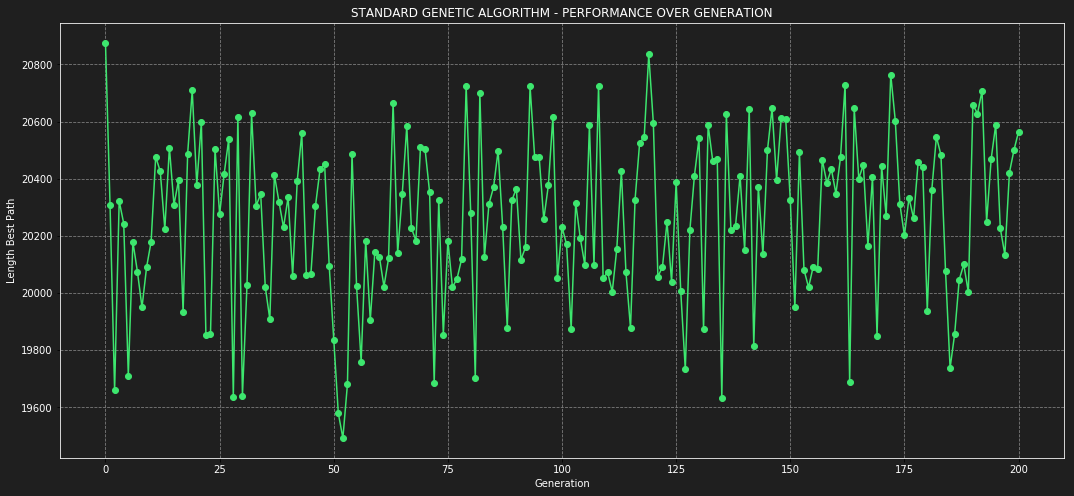

In [53]:
fig, ax = plt.subplots(figsize=(18,8))
fig.patch.set_facecolor(color=(0.12,0.12,0.12))
ax.set_facecolor((0.12,0.12,0.12))

ax.set_title('STANDARD GENETIC ALGORITHM - PERFORMANCE OVER GENERATION', color = (1,1,1))
ax.set_ylabel('Length Best Path', color = (1,1,1))
ax.set_xlabel('Generation', color = (1,1,1))

ax.set_facecolor((0.12,0.12,0.12))
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
plt.yticks(color=(1,1,1))
plt.xticks(color=(1,1,1))


ax.plot(range(0,len(all_f)), all_f, marker = 'o', c = '#3DE66E')
plt.show()

<p>But 200 generations are not enough to approximate the shortest path! It may take thousands of generations to get good results and such high numbers can drastically impact execution time.</p>

<h5>Clustered Genetic Algorithm</h5>

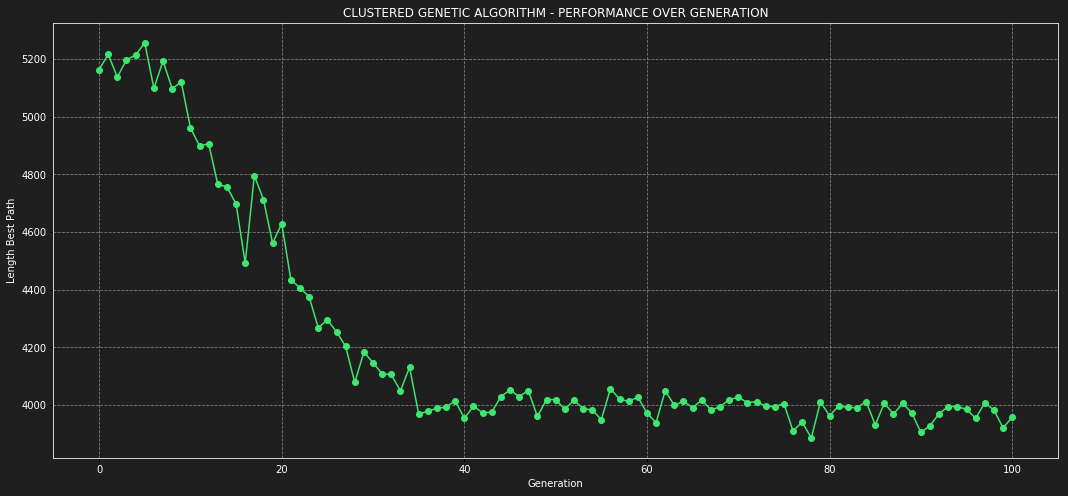

In [207]:
fig, ax = plt.subplots(figsize=(18,8))
fig.patch.set_facecolor(color=(0.12,0.12,0.12))
ax.set_facecolor((0.12,0.12,0.12))

ax.set_title('CLUSTERED GENETIC ALGORITHM - PERFORMANCE OVER GENERATION', color = (1,1,1))
ax.set_ylabel('Length Best Path', color = (1,1,1))
ax.set_xlabel('Generation', color = (1,1,1))

ax.set_facecolor((0.12,0.12,0.12))
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
plt.yticks(color=(1,1,1))
plt.xticks(color=(1,1,1))


ax.plot(range(0,len(all_fit)), all_fit, marker = 'o', c = '#3DE66E')
plt.show()

<p>Instead Clustered Genetic Algorithm seems to converge to a minimum in just 40 generations! Since the number of states is 196, the number of possible combinations to be evaluated to be sure of finding the path with the minimum length is <i>factorial of 196</i>, whose result is a <u>360-digit number</u>. The number of paths evaluated by Clustered Genetic Algorithm is instead: <i>population_size x n_gen</i> (50 x 100 = 5000; but as we have just seen, it is possible to obtain good results evaluating 2000 paths).</p>
<br>